In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import scipy.io
from PIL import Image
import pandas as pd
from torch.utils.data.dataset import random_split

sz = 448
test_transform=transforms.Compose([
                    transforms.Resize((sz, sz)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                ])

from new_loader import CUBDataset1, DOGDataset1


def cub_and_dogs(cub_root = "./CUB_200_2011",
                 dog_root = "./dog/dog",
                data_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                                                    ]),
                 bs=128
                 ):


    train_dataset_dog = DOGDataset1(image_root_path=f"{dog_root}", transform=data_transform, split="train")
    lengths = [int(len(train_dataset_dog) * 0.9), int(len(train_dataset_dog) * 0.1)]
    torch.manual_seed(0)
    train_set_dog, val_set_dog = random_split(train_dataset_dog, lengths)
    test_dataset_dog = DOGDataset1(image_root_path=f"{dog_root}", transform=test_transform, split="test")

    train_dataset_cub = CUBDataset1(image_root_path=f"{cub_root}", transform=data_transform, split="train", concat=True)
    lengths = [int(len(train_dataset_cub) * 0.9), int(len(train_dataset_cub) * 0.1) + 1]
    torch.manual_seed(0)
    train_set_cub, val_set_cub = random_split(train_dataset_cub, lengths)
    test_dataset_cub = CUBDataset1(image_root_path=f"{cub_root}", transform=test_transform, split="test", concat=True)


    train_dataloader = torch.utils.data.DataLoader(
                 torch.utils.data.ConcatDataset([train_set_dog, train_set_cub]),
                 batch_size=bs, shuffle=True,
                 num_workers=1, pin_memory=True)

    val_dataloader = torch.utils.data.DataLoader(
        torch.utils.data.ConcatDataset([val_set_dog, val_set_cub ]),
        batch_size=bs, shuffle=True,
        num_workers=1, pin_memory=True)


    test_dataloader = torch.utils.data.DataLoader(
                 torch.utils.data.ConcatDataset([test_dataset_dog, test_dataset_cub]),
                 batch_size=bs, shuffle=False,
                 num_workers=1, pin_memory=True)

    return train_dataloader, val_dataloader, test_dataloader

In [2]:
train_loader, val_loader, test_loader = cub_and_dogs()

In [3]:
len(train_loader),  len(val_loader), len(test_loader)

(127, 15, 113)

In [7]:
import timm 

model = timm.create_model('resnetv2_50x1_bitm', pretrained=True)
model

ResNetV2(
  (stem): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm3)

In [8]:
model.head = nn.Sequential(
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Conv2d(2048, 320, kernel_size=(1, 1), stride=(1, 1)),
    nn.Flatten(start_dim=1, end_dim=-1)
)

In [6]:
model

ResNetV2(
  (stem): Sequential(
    (conv): StdConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (pad): ConstantPad2d(padding=(1, 1, 1, 1), value=0.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stages): Sequential(
    (0): ResNetStage(
      (blocks): Sequential(
        (0): PreActBottleneck(
          (downsample): DownsampleConv(
            (conv): StdConv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm): Identity()
          )
          (norm1): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv1): StdConv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): GroupNormAct(
            32, 64, eps=1e-05, affine=True
            (act): ReLU(inplace=True)
          )
          (conv2): StdConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (norm3)

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model.cuda()

In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
#         for param in model.parameters():
#             param.requires_grad = False
        ct = 0
        for child in model.children():
            ct += 1
            if ct < 4:
                for param in child.parameters():
                    param.requires_grad = False

set_parameter_requires_grad(model, True)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 655,680 trainable parameters


In [12]:
learning_rate = 0.0001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [13]:
# Train the model
num_epochs = 50
total_step = len(train_loader)
curr_lr = learning_rate
# val_losses = np.array([])
# train_losses = np.array([])
val_losses = []
train_losses = []

val_acc = []
train_acc = []

myfile = open('myfile_txt', 'w')
myfile.write('Training results: \n')

for epoch in range(num_epochs):
    running_loss = 0
    correct=0
    total=0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        # print(images.shape)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimizes
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if (i+1) % 10 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Train Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    train_loss = running_loss / len(train_loader)
    acc = 100.*correct/total

    train_losses.append(train_loss)
    train_acc.append(acc)
    print('Train loss at epoch {} is {:.4f}'.format(epoch+1, train_loss))
    print('Train acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Train loss at epoch {} is {:.4f}\n'.format(epoch+1, train_loss))
    myfile.write('Train acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))
    myfile.write('---------------------------')
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_loss = loss / len(val_loader) 
    acc = 100.*correct/total
    val_losses.append(val_loss)
    val_acc.append(acc)
    print('Val loss at epoch {} is {:.4f}'.format(epoch+1, val_loss))
    print('Val acc at epoch {} is {:.4f}'.format(epoch+1, acc))
    myfile.write('Val loss at epoch {} is {:.4f}\n'.format(epoch+1, val_loss))
    myfile.write('Val acc at epoch {} is {:.4f}\n'.format(epoch+1, acc))    
    myfile.write('---------------------------\n')
    myfile.write('---------------------------\n')
    # Decay learning rate
    if (epoch+1) % 10 == 0:
        curr_lr /= 3
        update_lr(optimizer, curr_lr)

myfile.close()

Epoch [1/50], Step [10/127] Train Loss: 5.5031
Epoch [1/50], Step [20/127] Train Loss: 4.9878
Epoch [1/50], Step [30/127] Train Loss: 4.7071
Epoch [1/50], Step [40/127] Train Loss: 4.2701
Epoch [1/50], Step [50/127] Train Loss: 4.0466
Epoch [1/50], Step [60/127] Train Loss: 3.5301
Epoch [1/50], Step [70/127] Train Loss: 3.2696
Epoch [1/50], Step [80/127] Train Loss: 2.8513
Epoch [1/50], Step [90/127] Train Loss: 2.8932
Epoch [1/50], Step [100/127] Train Loss: 2.6899
Epoch [1/50], Step [110/127] Train Loss: 2.5654
Epoch [1/50], Step [120/127] Train Loss: 2.4931
Train loss at epoch 1 is 3.7097
Train acc at epoch 1 is 24.9599
Val loss at epoch 1 is 0.1654
Val acc at epoch 1 is 27.5314
Epoch [2/50], Step [10/127] Train Loss: 1.9847
Epoch [2/50], Step [20/127] Train Loss: 2.0108
Epoch [2/50], Step [30/127] Train Loss: 2.0796
Epoch [2/50], Step [40/127] Train Loss: 1.8342
Epoch [2/50], Step [50/127] Train Loss: 1.7639
Epoch [2/50], Step [60/127] Train Loss: 1.6339
Epoch [2/50], Step [70/127]

Train loss at epoch 12 is 0.3731
Train acc at epoch 12 is 92.0403
Val loss at epoch 12 is 0.0242
Val acc at epoch 12 is 90.6024
Epoch [13/50], Step [10/127] Train Loss: 0.3995
Epoch [13/50], Step [20/127] Train Loss: 0.3040
Epoch [13/50], Step [30/127] Train Loss: 0.4181
Epoch [13/50], Step [40/127] Train Loss: 0.3186
Epoch [13/50], Step [50/127] Train Loss: 0.4151
Epoch [13/50], Step [60/127] Train Loss: 0.3588
Epoch [13/50], Step [70/127] Train Loss: 0.3821
Epoch [13/50], Step [80/127] Train Loss: 0.3480
Epoch [13/50], Step [90/127] Train Loss: 0.2903
Epoch [13/50], Step [100/127] Train Loss: 0.3824
Epoch [13/50], Step [110/127] Train Loss: 0.4116
Epoch [13/50], Step [120/127] Train Loss: 0.4365
Train loss at epoch 13 is 0.3639
Train acc at epoch 13 is 92.1205
Val loss at epoch 13 is 0.0430
Val acc at epoch 13 is 90.7025
Epoch [14/50], Step [10/127] Train Loss: 0.4356
Epoch [14/50], Step [20/127] Train Loss: 0.2728
Epoch [14/50], Step [30/127] Train Loss: 0.2515
Epoch [14/50], Step [

Epoch [24/50], Step [70/127] Train Loss: 0.2584
Epoch [24/50], Step [80/127] Train Loss: 0.2807
Epoch [24/50], Step [90/127] Train Loss: 0.3157
Epoch [24/50], Step [100/127] Train Loss: 0.2131
Epoch [24/50], Step [110/127] Train Loss: 0.3367
Epoch [24/50], Step [120/127] Train Loss: 0.2992
Train loss at epoch 24 is 0.2769
Train acc at epoch 24 is 94.7511
Val loss at epoch 24 is 0.0564
Val acc at epoch 24 is 93.1088
Epoch [25/50], Step [10/127] Train Loss: 0.1978
Epoch [25/50], Step [20/127] Train Loss: 0.2969
Epoch [25/50], Step [30/127] Train Loss: 0.2538
Epoch [25/50], Step [40/127] Train Loss: 0.3143
Epoch [25/50], Step [50/127] Train Loss: 0.2946
Epoch [25/50], Step [60/127] Train Loss: 0.2554
Epoch [25/50], Step [70/127] Train Loss: 0.3035
Epoch [25/50], Step [80/127] Train Loss: 0.2723
Epoch [25/50], Step [90/127] Train Loss: 0.2736
Epoch [25/50], Step [100/127] Train Loss: 0.2417
Epoch [25/50], Step [110/127] Train Loss: 0.2609
Epoch [25/50], Step [120/127] Train Loss: 0.2188
Tr

Epoch [36/50], Step [10/127] Train Loss: 0.1958
Epoch [36/50], Step [20/127] Train Loss: 0.2839
Epoch [36/50], Step [30/127] Train Loss: 0.2070
Epoch [36/50], Step [40/127] Train Loss: 0.2448
Epoch [36/50], Step [50/127] Train Loss: 0.2654
Epoch [36/50], Step [60/127] Train Loss: 0.3023
Epoch [36/50], Step [70/127] Train Loss: 0.2474
Epoch [36/50], Step [80/127] Train Loss: 0.2694
Epoch [36/50], Step [90/127] Train Loss: 0.2502
Epoch [36/50], Step [100/127] Train Loss: 0.3562
Epoch [36/50], Step [110/127] Train Loss: 0.2545
Epoch [36/50], Step [120/127] Train Loss: 0.2213
Train loss at epoch 36 is 0.2512
Train acc at epoch 36 is 95.4860
Val loss at epoch 36 is 0.0180
Val acc at epoch 36 is 93.7479
Epoch [37/50], Step [10/127] Train Loss: 0.2900
Epoch [37/50], Step [20/127] Train Loss: 0.2515
Epoch [37/50], Step [30/127] Train Loss: 0.2526
Epoch [37/50], Step [40/127] Train Loss: 0.2450
Epoch [37/50], Step [50/127] Train Loss: 0.3370
Epoch [37/50], Step [60/127] Train Loss: 0.2684
Epoch

Epoch [47/50], Step [100/127] Train Loss: 0.1675
Epoch [47/50], Step [110/127] Train Loss: 0.2064
Epoch [47/50], Step [120/127] Train Loss: 0.1969
Train loss at epoch 47 is 0.2443
Train acc at epoch 47 is 95.6774
Val loss at epoch 47 is 0.0964
Val acc at epoch 47 is 93.9369
Epoch [48/50], Step [10/127] Train Loss: 0.2461
Epoch [48/50], Step [20/127] Train Loss: 0.3148
Epoch [48/50], Step [30/127] Train Loss: 0.2478
Epoch [48/50], Step [40/127] Train Loss: 0.1927
Epoch [48/50], Step [50/127] Train Loss: 0.2410
Epoch [48/50], Step [60/127] Train Loss: 0.2635
Epoch [48/50], Step [70/127] Train Loss: 0.2793
Epoch [48/50], Step [80/127] Train Loss: 0.2034
Epoch [48/50], Step [90/127] Train Loss: 0.2069
Epoch [48/50], Step [100/127] Train Loss: 0.2339
Epoch [48/50], Step [110/127] Train Loss: 0.2845
Epoch [48/50], Step [120/127] Train Loss: 0.2442
Train loss at epoch 48 is 0.2439
Train acc at epoch 48 is 95.7083
Val loss at epoch 48 is 0.0877
Val acc at epoch 48 is 93.9647
Epoch [49/50], Ste

### Way to get information about class names --> Labels

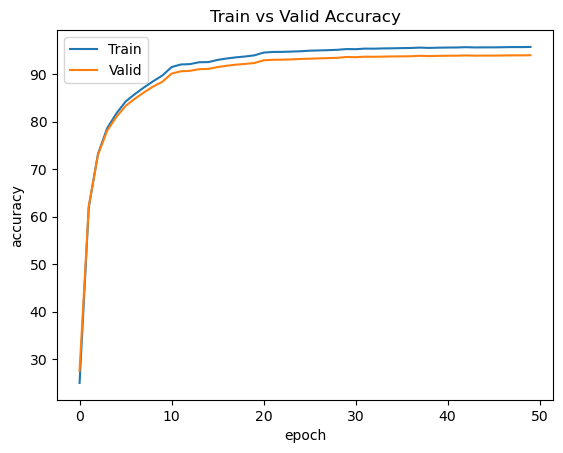

In [15]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

In [16]:

torch.save(model.state_dict(), 'model_checkpoints/model_resnetv2_cub_dog_epoch50.pth')

In [18]:
 # Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Accuracy of the model on the test images: 95.77003828578486 %
